Найдена скорость: '72KM/y' с уверенностью 0.51
Область скорости определена: (282, 1020, 362, 1044)

Кадр 356:

Кадр 445:

Кадр 534:
Найдена скорость: '69KM/4' с уверенностью 0.81

Кадр 623:
Найдена скорость: '68KM/y' с уверенностью 0.53

Кадр 712:

Кадр 801:
Найдена скорость: '76KM/y' с уверенностью 0.44

Кадр 890:
Найдена скорость: '79KM/y' с уверенностью 0.55

Кадр 979:

Кадр 1068:

Кадр 1157:

Кадр 1246:

Кадр 1335:

Кадр 1424:

Кадр 1513:
Найдена скорость: '63KM/y' с уверенностью 0.68

Кадр 1602:

Кадр 1691:
Найдена скорость: '72KM/y' с уверенностью 0.53

Кадр 1780:
Найдена скорость: '78KM/4' с уверенностью 0.83

Кадр 1869:
Найдена скорость: '84KM/y' с уверенностью 0.52

Кадр 1958:
Найдена скорость: '86KM/y' с уверенностью 0.47

Кадр 2047:
Найдена скорость: '87KM/y' с уверенностью 0.60

Кадр 2136:

Кадр 2225:
Найдена скорость: '72Km/y' с уверенностью 0.49

Кадр 2314:
Найдена скорость: '59Km/y' с уверенностью 0.60

Кадр 2403:
Найдена скорость: '55Km/y' с уверенностью 0.42

Кадр 2492

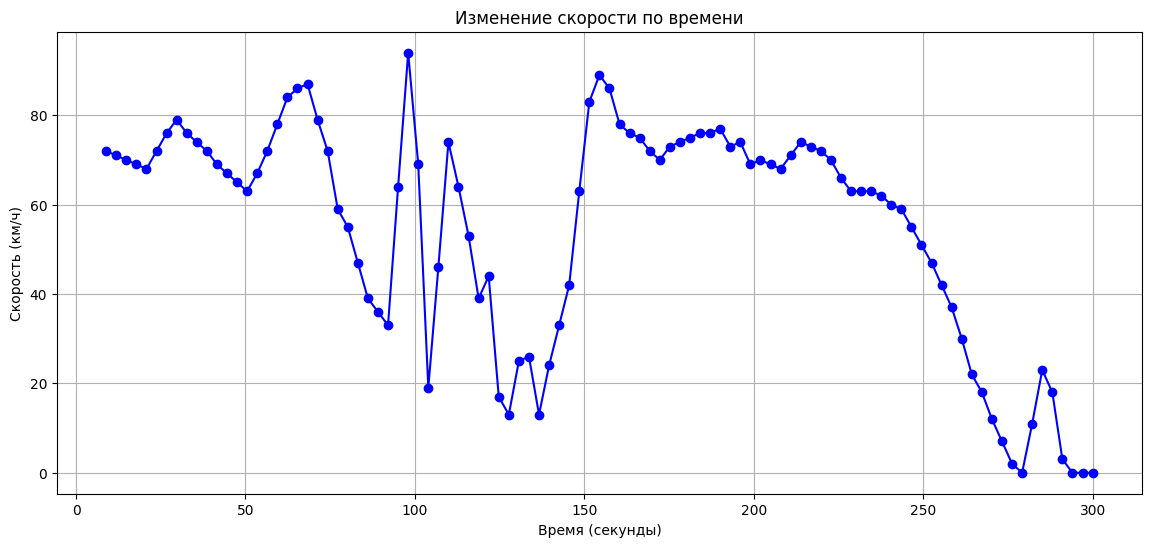

Кадр 267: скорость 72 км/ч
Кадр 356: скорость 71 км/ч
Кадр 445: скорость 70 км/ч
Кадр 534: скорость 69 км/ч
Кадр 623: скорость 68 км/ч
Кадр 712: скорость 72 км/ч
Кадр 801: скорость 76 км/ч
Кадр 890: скорость 79 км/ч
Кадр 979: скорость 76 км/ч
Кадр 1068: скорость 74 км/ч
Кадр 1157: скорость 72 км/ч
Кадр 1246: скорость 69 км/ч
Кадр 1335: скорость 67 км/ч
Кадр 1424: скорость 65 км/ч
Кадр 1513: скорость 63 км/ч
Кадр 1602: скорость 67 км/ч
Кадр 1691: скорость 72 км/ч
Кадр 1780: скорость 78 км/ч
Кадр 1869: скорость 84 км/ч
Кадр 1958: скорость 86 км/ч
Кадр 2047: скорость 87 км/ч
Кадр 2136: скорость 79 км/ч
Кадр 2225: скорость 72 км/ч
Кадр 2314: скорость 59 км/ч
Кадр 2403: скорость 55 км/ч
Кадр 2492: скорость 47 км/ч
Кадр 2581: скорость 39 км/ч
Кадр 2670: скорость 36 км/ч
Кадр 2759: скорость 33 км/ч
Кадр 2848: скорость 64 км/ч
Кадр 2937: скорость 94 км/ч
Кадр 3026: скорость 69 км/ч
Кадр 3115: скорость 19 км/ч
Кадр 3204: скорость 46 км/ч
Кадр 3293: скорость 74 км/ч
Кадр 3382: скорость 64 км/ч
К

In [2]:
import cv2
import easyocr
import re
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Проверка наличия GPU
use_gpu = torch.cuda.is_available()

# Инициализация EasyOCR reader с использованием GPU, если доступен
reader = easyocr.Reader(['en'], gpu=use_gpu)

# Расширенное регулярное выражение для поиска значений скорости
km_pattern = re.compile(r'\b\d+\s?[kK][mM](?:/y|/ч|/h)?\b')

# Координаты области, где была обнаружена скорость
speed_region = None

def process_frame(frame, region=None):
    """
    Обрабатывает один кадр, считывает текст и возвращает данные о тексте.
    """
    if region:
        # Обрезаем кадр до области, где была найдена скорость
        frame = frame[region[1]:region[3], region[0]:region[2]]
    
    results = reader.readtext(frame, detail=1)
    return results

def find_speed_region(results):
    """
    Ищет область, содержащую текст скорости, используя регулярное выражение.
    """
    for (bbox, text, prob) in results:
        if km_pattern.search(text) and prob > 0.4:
            print(f"Найдена скорость: '{text}' с уверенностью {prob:.2f}")
            return bbox  # Возвращаем координаты области (top_left, bottom_right)
    return None

def normalize_speed(text):
    """
    Приводит найденное значение скорости к числовому формату.
    """
    match = re.search(r'\d+', text)
    if match:
        return int(match.group())
    return None

def interpolate_speeds(frames, speeds):
    """
    Интерполирует пропущенные значения скорости и возвращает только положительные значения.
    """
    valid_indices = [i for i, s in enumerate(speeds) if s is not None]
    valid_frames = [frames[i] for i in valid_indices]
    valid_speeds = [s for s in speeds if s is not None]

    if len(valid_frames) < 2:
        # Недостаточно данных для интерполяции
        return speeds

    interpolation_function = interp1d(valid_frames, valid_speeds, kind='linear', fill_value='extrapolate')
    interpolated_speeds = interpolation_function(frames)

    # Убедимся, что все значения положительные
    return [max(0, int(s)) for s in interpolated_speeds]

def process_video(video_path):
    """
    Обрабатывает видеофайл, извлекает текст с каждого кадра и выводит результаты в консоль.
    """
    global speed_region

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps * 3)  # Обрабатываем кадры каждые 3 секунды
    frame_count = 0
    speeds = []
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        if frame_count % frame_interval == 0:
            if speed_region is None:
                # Ищем скорость на всем кадре, если область еще не найдена
                results = process_frame(frame)
                region = find_speed_region(results)
                if region:
                    x1, y1 = int(region[0][0]), int(region[0][1])
                    x2, y2 = int(region[2][0]), int(region[2][1])
                    speed_region = (x1, y1, x2, y2)
                    print(f"Область скорости определена: {speed_region}")
                    # Нормализуем значение скорости
                    for (_, text, _) in results:
                        if km_pattern.search(text):
                            speed = normalize_speed(text)
                            speeds.append(speed)
                            frames.append(frame_count)
                            break
            else:
                # Ищем только в заданной области
                results = process_frame(frame, region=speed_region)
                print(f"\nКадр {frame_count}:")
                found_speed = None
                for (_, text, prob) in results:
                    if km_pattern.search(text) and prob > 0.4:
                        found_speed = normalize_speed(text)
                        print(f"Найдена скорость: '{text}' с уверенностью {prob:.2f}")
                        break
                
                speeds.append(found_speed)
                frames.append(frame_count)

    cap.release()
    print('Обработка видео завершена.')

    # Интерполяция пропущенных значений
    speeds = interpolate_speeds(frames, speeds)

    # Построение графика скорости
    plt.figure(figsize=(14, 6))
    plt.plot([f / fps for f in frames], speeds, marker='o', linestyle='-', color='b')
    plt.xlabel('Время (секунды)')
    plt.ylabel('Скорость (км/ч)')
    plt.title('Изменение скорости по времени')
    plt.grid(True)
    plt.show()

    # Вывод интерполированных значений
    for f, s in zip(frames, speeds):
        print(f"Кадр {f}: скорость {s} км/ч")

# Путь к видеофайлу
video_path = 'AKN00048.mp4'
process_video(video_path)
